In [1]:
import matplotlib.pyplot as plt

import sys, os
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
# Read data from file 'Hitters.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later)
data = pd.read_csv("Hitters.csv")

In [3]:
# Preview the first 5 lines of the loaded data 
print(data.head())

          Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   

   CHits    ...      CRuns  CRBI  CWalks  League Division PutOuts  Assists  \
0     66    ...         30    29      14       A        E     446       33   
1    835    ...        321   414     375       N        W     632       43   
2    457    ...        224   266     263       A        W     880       82   
3   1575    ...        828   838     354       N        E     200       11   
4    101    ...         48    46      33       N        E     805       40   

   Errors  Salary  NewLeague  
0      20     NaN          A  
1     

In [4]:
# Extract only numeric columns
numeric_col_idx = []
for idx, t in enumerate(data.dtypes):
    if str(t) in ["int64", "float64"]:
        numeric_col_idx.append(idx)
numeric_data = data.iloc[:,numeric_col_idx]

In [5]:
# Remove NaN data
numeric_data = numeric_data.dropna()

# Preview the first 5 lines
print(numeric_data.head())

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
1   414     375      632       43      10   475.0  
2   266     263      880       82      14   480.0  
3   838     354      200       11       3   500.0  
4    46      33      805       40       4    91.5  
5   336     194      282      421      25   750.0  


In [6]:
# Prepare data
X = numeric_data.iloc[:,:-1]
Y = numeric_data.iloc[:,-1]

print("Record number: " + str(len(Y)))

Record number: 263


In [7]:
# Ridge test with different alphas
ridge = linear_model.Ridge(normalize=True)

In [8]:
# Try several alphas
coefs = []
alphas = np.logspace(-10, 10, 200)

is_print = False
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, Y)
    coefs.append(ridge.coef_)

    # Check the last three features left
    if len([ c for c in ridge.coef_ if c != 0 ]) == 3 and not is_print:
        last_three_feature = []
        for idx in [ i for i, c in enumerate(ridge.coef_) if c != 0 ]:
            last_three_feature.append(list(X)[idx])
        print("The last three features are " + ", ".join(last_three_feature)) # Hits, CRuns, CRBI 
        is_print = True
if not is_print:
    print("There is no last three features, all features still are not zero")

There is no last three features, all features still are not zero


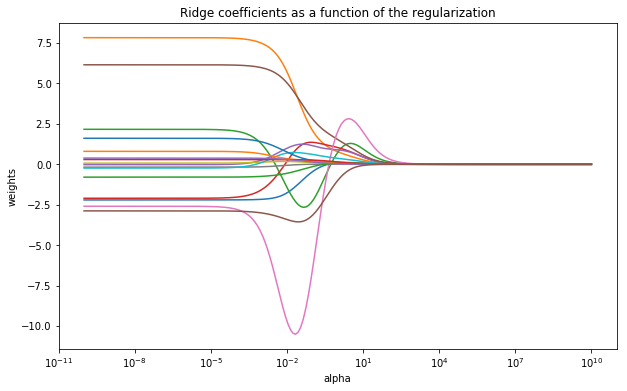

In [9]:
# Plot alpha-coefficient relation
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.title('Ridge coefficients as a function of the regularization')

In [10]:
# Find the optimal alpha by cross-validation
ridgecv = linear_model.RidgeCV(alphas=alphas, cv=10, normalize=True)
ridgecv.fit(X, Y)
opitmal_alpha = ridgecv.alpha_
print(opitmal_alpha)

0.890735463861


In [11]:
# Build model using the optimal alpha
ridge.set_params(alpha=opitmal_alpha)
ridge.fit(X, Y)

Ridge(alpha=0.89073546386104585, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [12]:
# Check coefficients
print(ridge.coef_)
print("Feature number left in the model: " + str(len([ x for x in ridge.coef_ if x != 0 ])))

[ 0.08674217  0.80568842  0.62016761  1.05613654  0.90345245  1.58023793
  1.81854933  0.01128474  0.05443362  0.37919733  0.1097045   0.11348264
  0.06408795  0.15619471  0.02728474 -1.09902899]
Feature number left in the model: 16


In [13]:
# Check MSE for optimal alpha
y_pred = ridge.predict(X)
mse = mean_squared_error(Y, y_pred)
print("MSE: {0}".format(mse))

MSE: 113323.37111528685


In [14]:
# Plot MSE-alpha relationship
# Get both training MSE and validaiton MSE for each alpha

train_error_list = []
test_error_list = []
error_list = []

for a in alphas:
    # Sum of errors
    sum_train_mse = 0
    sum_test_mse = 0
    
    # Use 10-Fold cross validation for more reliability
    kf = KFold(n_splits=10)
    
    for train_index, test_index in kf.split(X):
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        # Build model
        ridge.set_params(alpha=a)
        ridge.fit(x_train, y_train)
        sum_train_mse += mean_squared_error(y_train, ridge.predict(x_train))
        sum_test_mse += mean_squared_error(y_test, ridge.predict(x_test))
    
    # Get average of MSE of 10-Fold cross validation
    train_mse = sum_train_mse / kf.get_n_splits(X,Y)
    test_mse = sum_test_mse / kf.get_n_splits(X,Y)
    
    # Add to lists
    train_error_list.append(train_mse)
    test_error_list.append(test_mse)
    error_list.append([train_mse,test_mse])

Model complexity is reversed of alpha value. This means high alpha gives a simpler model, on the other hands, low alpha indicates more complex the model is.

(1e-07, 1000)

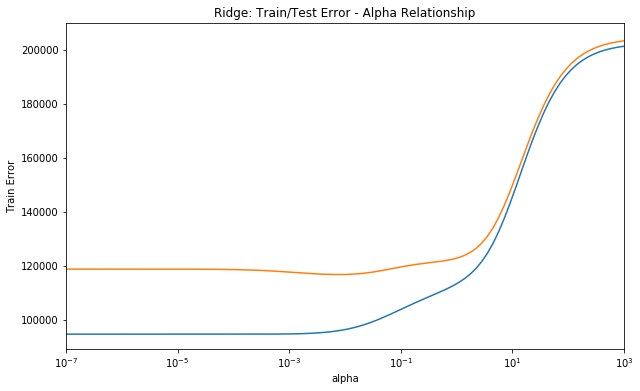

In [15]:
# Plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, error_list)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Train Error')
plt.axis('tight')
plt.title('Ridge: Train/Test Error - Alpha Relationship')
plt.xlim(1e-7, 1000)